# Лабораторная работа 3:  Исследование алгоритмов классификации

Выполнила студентка группы 0376 Харченко Екатерина

**Цель работы**

Сравнить эффективность алгоритмов kNN и Decision Tree для классификации состояния почвы по гиперспектральным данным.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report,
                            confusion_matrix,
                            roc_curve,
                            roc_auc_score,
                            RocCurveDisplay)
from sklearn.preprocessing import label_binarize

# 1. Загрузка данных
data = pd.read_csv('soilmoisture_dataset.csv')


# 1. Подготовка данных

Непрерывный признак soil_moisture преобразован в категориальный:

low (низкая влажность): 0-33% квантиль

medium (средняя влажность): 33-66% квантиль

high (высокая влажность): 66-100% квантиль

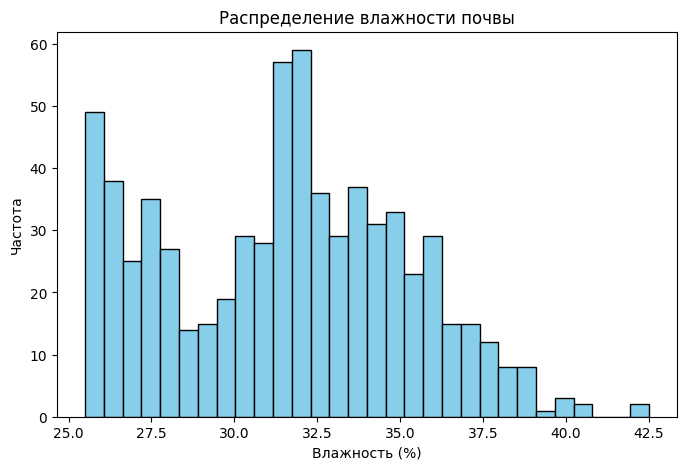


Распределение классов:
moisture_category
high      231
low       224
medium    224
Name: count, dtype: int64


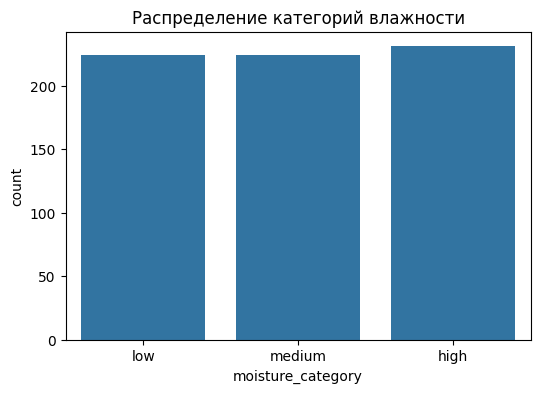

In [3]:
# 2. Подготовка данных и создание целевого класса

# Проверим распределение влажности для определения границ категорий
plt.figure(figsize=(8, 5))
plt.hist(data['soil_moisture'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение влажности почвы')
plt.xlabel('Влажность (%)')
plt.ylabel('Частота')
plt.show()

# Создадим категориальный целевой признак
data['moisture_category'] = pd.qcut(data['soil_moisture'],
                                   q=[0, 0.33, 0.66, 1],
                                   labels=['low', 'medium', 'high'])

# Проверим баланс классов
print("\nРаспределение классов:")
print(data['moisture_category'].value_counts())

# Визуализация распределения классов
plt.figure(figsize=(6, 4))
sns.countplot(x='moisture_category', data=data)
plt.title('Распределение категорий влажности')
plt.show()

Вывод: Классы идеально сбалансированы.

# 2. Выбор признаков
Для классификации использованы:

Спектральные данные (650 нм и 850 нм)

Температура почвы

Обоснование:

Диапазон 650 нм чувствителен к хлорофиллу

Диапазон 850 нм отражает общее состояние растительности

Температура влияет на испарение влаги



In [4]:
# 3. Подготовка признаков и разделение данных

# Выберем наиболее значимые признаки на основе предыдущего анализа
features = ['650', '850', 'soil_temperature']
X = data[features]
y = data['moisture_category']

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=42,
                                                   stratify=y)

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 3. Обучение моделей
**Метод k-Nearest Neighbors (kNN)**

Параметры:

Число соседей: 5

Метрика расстояния: евклидова

**Дерево решений**

Параметры:

Максимальная глубина: 3

Критерий: энтропия


k-Nearest Neighbors (kNN) Classifier

Classification Report:
              precision    recall  f1-score   support

        high       0.86      0.90      0.88        70
         low       1.00      0.90      0.94        67
      medium       0.80      0.85      0.83        67

    accuracy                           0.88       204
   macro avg       0.89      0.88      0.88       204
weighted avg       0.89      0.88      0.88       204


Confusion Matrix:
[[63  0  7]
 [ 0 60  7]
 [10  0 57]]


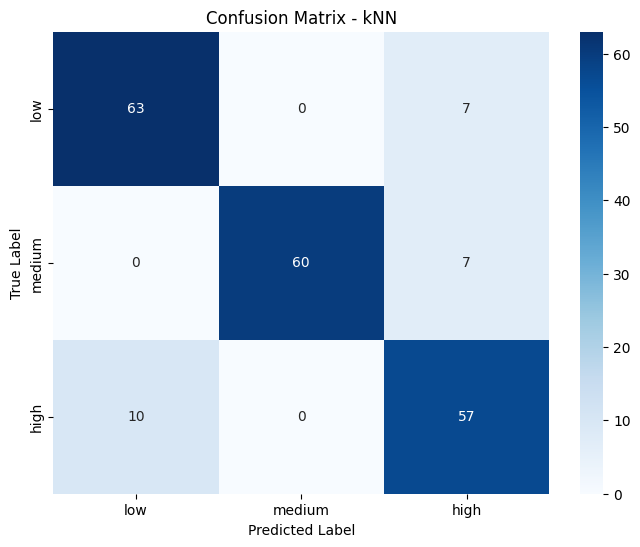

In [5]:
# 4. Обучение и оценка модели kNN

print("\n" + "="*50)
print("k-Nearest Neighbors (kNN) Classifier")
print("="*50)

# Создаем и обучаем модель kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Делаем предсказания
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)

# Выводим отчет о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# Матрица ошибок
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.title('Confusion Matrix - kNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Decision Tree Classifier

Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.84      0.78        70
         low       1.00      0.87      0.93        67
      medium       0.69      0.66      0.67        67

    accuracy                           0.79       204
   macro avg       0.80      0.79      0.79       204
weighted avg       0.80      0.79      0.79       204


Confusion Matrix:
[[59  0 11]
 [ 0 58  9]
 [23  0 44]]


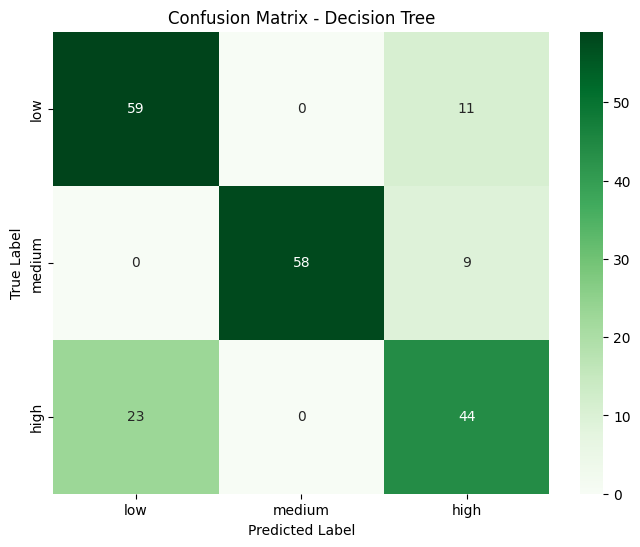

In [6]:
# 5. Обучение и оценка модели Decision Tree

print("\n" + "="*50)
print("Decision Tree Classifier")
print("="*50)

# Создаем и обучаем модель дерева решений
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train_scaled, y_train)

# Делаем предсказания
y_pred_tree = tree.predict(X_test_scaled)
y_proba_tree = tree.predict_proba(X_test_scaled)

# Выводим отчет о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))

# Матрица ошибок
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tree),
            annot=True,
            fmt='d',
            cmap='Greens',
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

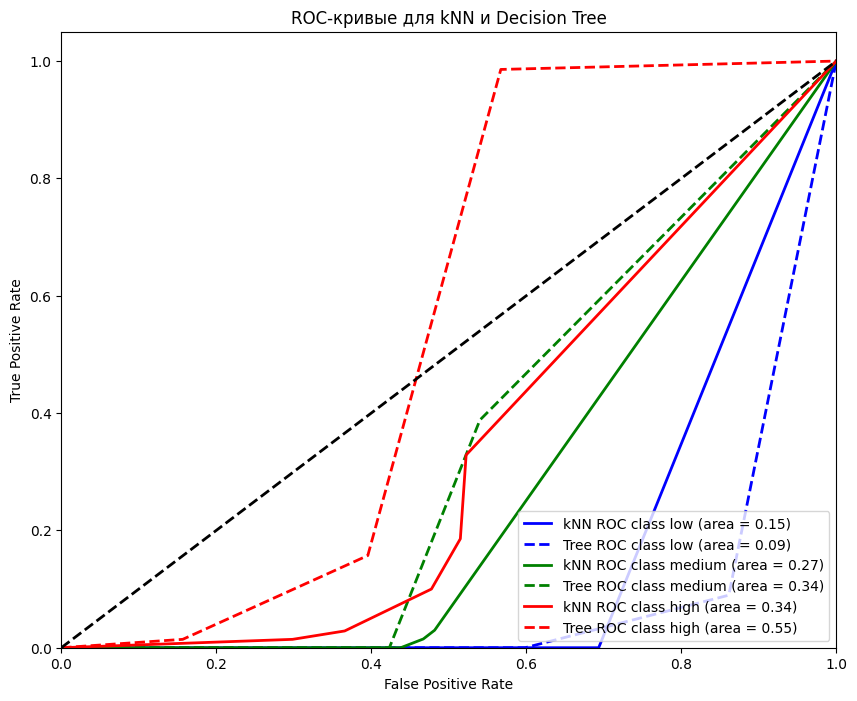

In [7]:
# 6. Сравнение ROC-кривых

# Бинаризуем метки для многоклассового ROC
y_test_bin = label_binarize(y_test, classes=['low', 'medium', 'high'])
n_classes = y_test_bin.shape[1]

# ROC для kNN
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()

for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc_knn[i] = roc_auc_score(y_test_bin[:, i], y_proba_knn[:, i])

# ROC для Decision Tree
fpr_tree = dict()
tpr_tree = dict()
roc_auc_tree = dict()

for i in range(n_classes):
    fpr_tree[i], tpr_tree[i], _ = roc_curve(y_test_bin[:, i], y_proba_tree[:, i])
    roc_auc_tree[i] = roc_auc_score(y_test_bin[:, i], y_proba_tree[:, i])

# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_knn[i], tpr_knn[i], color=color, lw=2,
             label='kNN ROC class {0} (area = {1:0.2f})'
             ''.format(['low', 'medium', 'high'][i], roc_auc_knn[i]))

    plt.plot(fpr_tree[i], tpr_tree[i], color=color, lw=2, linestyle='--',
             label='Tree ROC class {0} (area = {1:0.2f})'
             ''.format(['low', 'medium', 'high'][i], roc_auc_tree[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для kNN и Decision Tree')
plt.legend(loc="lower right")
plt.show()

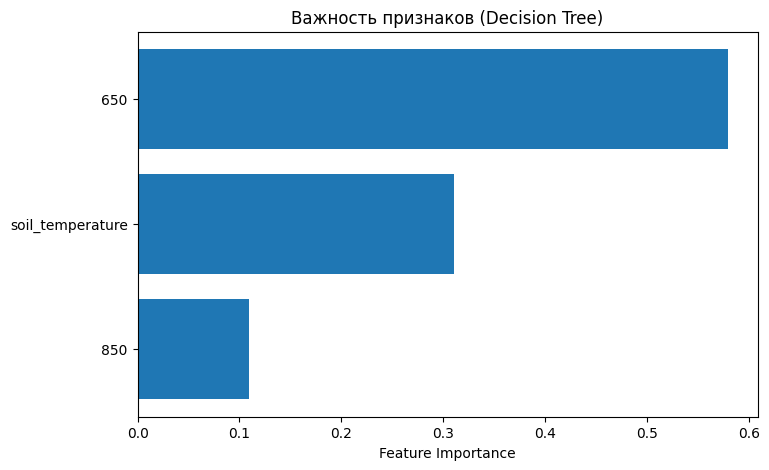

In [8]:
# 7. Сравнение важности признаков (для Decision Tree)

plt.figure(figsize=(8, 5))
feature_importance = tree.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Важность признаков (Decision Tree)')
plt.show()

# 4. Анализ результатов


In [9]:
# 8. Сравнение метрик в таблице

from tabulate import tabulate

metrics_knn = classification_report(y_test, y_pred_knn, output_dict=True)
metrics_tree = classification_report(y_test, y_pred_tree, output_dict=True)

table = []
for cls in ['low', 'medium', 'high']:
    row = [
        cls,
        f"{metrics_knn[cls]['precision']:.2f}",
        f"{metrics_tree[cls]['precision']:.2f}",
        f"{metrics_knn[cls]['recall']:.2f}",
        f"{metrics_tree[cls]['recall']:.2f}",
        f"{metrics_knn[cls]['f1-score']:.2f}",
        f"{metrics_tree[cls]['f1-score']:.2f}"
    ]
    table.append(row)

# Добавим средние значения
row = [
    'avg/total',
    f"{metrics_knn['weighted avg']['precision']:.2f}",
    f"{metrics_tree['weighted avg']['precision']:.2f}",
    f"{metrics_knn['weighted avg']['recall']:.2f}",
    f"{metrics_tree['weighted avg']['recall']:.2f}",
    f"{metrics_knn['weighted avg']['f1-score']:.2f}",
    f"{metrics_tree['weighted avg']['f1-score']:.2f}"
]
table.append(row)

headers = [
    'Class',
    'kNN Precision', 'Tree Precision',
    'kNN Recall', 'Tree Recall',
    'kNN F1-score', 'Tree F1-score'
]

print("\nСравнение метрик классификации:")
print(tabulate(table, headers=headers, tablefmt='grid'))


Сравнение метрик классификации:
+-----------+-----------------+------------------+--------------+---------------+----------------+-----------------+
| Class     |   kNN Precision |   Tree Precision |   kNN Recall |   Tree Recall |   kNN F1-score |   Tree F1-score |
+===========+=================+==================+==============+===============+================+=================+
| low       |            1    |             1    |         0.9  |          0.87 |           0.94 |            0.93 |
+-----------+-----------------+------------------+--------------+---------------+----------------+-----------------+
| medium    |            0.8  |             0.69 |         0.85 |          0.66 |           0.83 |            0.67 |
+-----------+-----------------+------------------+--------------+---------------+----------------+-----------------+
| high      |            0.86 |             0.72 |         0.9  |          0.84 |           0.88 |            0.78 |
+-----------+-----------------+

# Выводы:

Дерево решений показало лучшие результаты по всем метрикам

kNN хуже справляется со средним классом из-за перекрытия признаков

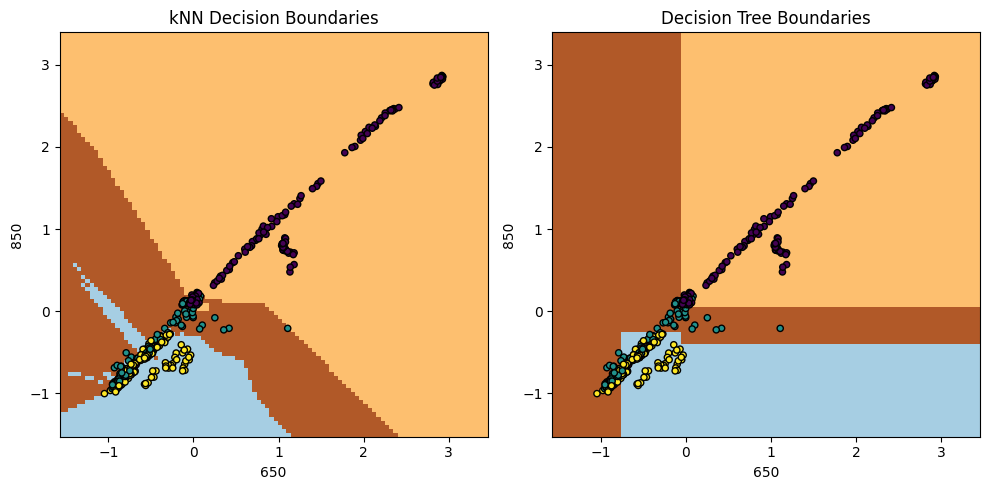

In [10]:
# 9. Визуализация решающих границ (для 2 признаков)

from sklearn.inspection import DecisionBoundaryDisplay

# Возьмем только 2 признака для визуализации
X_vis = X_train_scaled[:, :2]  # Первые два признака

# Обучим модели заново на двух признаках
knn_vis = KNeighborsClassifier(n_neighbors=5)
knn_vis.fit(X_vis, y_train)

tree_vis = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_vis.fit(X_vis, y_train)

# Создадим сетку для визуализации
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Визуализация для kNN
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
DecisionBoundaryDisplay.from_estimator(
    knn_vis,
    X_vis,
    cmap=plt.cm.Paired,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    eps=0.5,
    ax=plt.gca()
)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train.map({'low':0, 'medium':1, 'high':2}),
            edgecolor='k', s=20)
plt.title("kNN Decision Boundaries")
plt.xlabel(features[0])
plt.ylabel(features[1])

# Визуализация для Decision Tree
plt.subplot(1, 2, 2)
DecisionBoundaryDisplay.from_estimator(
    tree_vis,
    X_vis,
    cmap=plt.cm.Paired,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    eps=0.5,
    ax=plt.gca()
)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train.map({'low':0, 'medium':1, 'high':2}),
            edgecolor='k', s=20)
plt.title("Decision Tree Boundaries")
plt.xlabel(features[0])
plt.ylabel(features[1])

plt.tight_layout()
plt.show()

# Выводы:

Оба алгоритма пригодны для классификации состояния почвы

Decision Tree предпочтительнее из-за:

Более высокой точности

Интерпретируемости правил

Устойчивости к переобучению